
#### Preparing data
Run the next cells to download and prepare the datasets and util functions.


In [0]:
import sys
download_data = False

if 'google.colab' in sys.modules:
    download_data = True

In [0]:
if download_data:
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/DaielChom/ann_leaf_classification/master/init.py
    from init import download_utils, unzip_leaf_dataset, dataset_dir
    download_utils(force_download=False)

In [94]:
if download_data:
    !mkdir ./local/datasets/
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf" -O local/datasets/leaf.zip && rm -rf /tmp/cookies.txt

mkdir: cannot create directory ‘./local/datasets/’: File exists
--2020-04-30 02:50:33--  https://docs.google.com/uc?export=download&confirm=CpCr&id=1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf
Resolving docs.google.com (docs.google.com)... 108.177.97.102, 108.177.97.138, 108.177.97.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-84-docs.googleusercontent.com/docs/securesc/687g1kgvdvfq3k4rg7cabi8ugq7g0035/03vjt370kide906b9b24ghgd3jhaj65t/1588215000000/02012202667471862451/05687861178297716322Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download [following]
--2020-04-30 02:50:33--  https://doc-08-84-docs.googleusercontent.com/docs/securesc/687g1kgvdvfq3k4rg7cabi8ugq7g0035/03vjt370kide906b9b24ghgd3jhaj65t/1588215000000/02012202667471862451/05687861178297716322Z/1g5MPhz2YEW5nyuUqacQ_GVWpeDjVG-Cf?e=download
Resolving doc-08-84-docs.googleusercontent.com (doc-08-84-docs.googleuserc

In [0]:
if download_data:
    unzip_leaf_dataset()

Notebook start

In [96]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.2.0-rc3'

In [0]:
import os
import random
import numpy as np
import pandas as pd
import progressbar
import matplotlib.pyplot as plt

import local.lib as lib
from init import dataset_dir

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [0]:
data_dir = "./local/datasets/"

### Read data from the CSV file

In [99]:
#here we split the data
split=0.8
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


### Target onehot 

In [0]:
y_train_oh = np.eye(99)[y_train]#num_classes
y_test_oh  = np.eye(num_classes)[y_test]

In [0]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [102]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((792, 194), (792, 128, 128, 1), (792, 99))

In [103]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((198, 194), (198, 128, 128), (198, 99))

In [0]:
x_trainif = np.r_[[i.flatten() for i in X_train_ri]]
x_testif  = np.r_[[i.flatten() for i in X_test_ri]]

In [105]:
x_trainif.shape, x_testif.shape

((792, 16384), (198, 16384))

In [0]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras

In [0]:
def get_model(input_dim=784, output_dim=10, num_hidden_layers=6, hidden_size=10, activation="relu"):

    clear_session()
    model = Sequential()
    model.add(Dense(hidden_size, activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))
    
    for i in range(num_hidden_layers):
        model.add(Dense(hidden_size, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(num_hidden_layers+1)))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

In [0]:
num_layers=[2,3,4,5,6,7,8,9,10]
neuron_per_layer=[3,5,10,30]
activations=["relu", "sigmoid", tf.nn.leaky_relu ]

In [0]:
import itertools

In [0]:
 acc_test = pd.DataFrame(np.zeros((len(num_layers)*len(neuron_per_layer), len(activations)))*np.nan, index=[[str(a)+"-"+str(b) for a,b in itertools.product (num_layers, neuron_per_layer)]], columns=[str(i) for i in activations])

In [0]:
A=np.zeros( (108),float)#accuracy
B=np.zeros( (108),float)#

In [0]:
train_time = pd.DataFrame(np.zeros((len(num_layers)*len(neuron_per_layer), len(activations)))*np.nan, index=[[str(a)+"-"+str(b) for a,b in itertools.product (num_layers, neuron_per_layer)]], columns=[str(i) for i in activations])

In [113]:
x_trainif.shape[1], y_test_oh.shape[1]

(16384, 99)

In [115]:
import time
i=0

for act,nl ,nn in itertools.product(activations,num_layers, neuron_per_layer):#
    t1=time.time()
    model=get_model(input_dim=x_trainif.shape[1],output_dim=y_test_oh.shape[1], num_hidden_layers=nl, hidden_size=nn, activation=act)
    model.fit(x_trainif, y_train_oh, epochs=50, batch_size=32, validation_data=( x_testif, y_test_oh),verbose=0)
    preds_train = model.predict(x_trainif).argmax(axis=1)
    preds_test = model.predict( x_testif).argmax(axis=1)
    preds_train
    print("accuracy train %.3f"%(np.mean(preds_train==y_train)))#y_train   
    print("accuracy test %.3f"%(np.mean(preds_test==y_test)))
    accuracy=np.mean(preds_test==y_test)
    t2=time.time()
    A[i]=accuracy
    B[i]=t2.real-t1.real
    i=i+1

accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.071
accuracy test 0.051
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.755
accuracy test 0.293
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.232
accuracy test 0.152
accuracy train 0.500
accuracy test 0.227
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.010
accuracy test 0.010
accuracy train 0.150
accuracy test 0.091
accuracy train 0.023
accuracy test 0.020
accuracy train 0.032
accuracy test 0.030
accuracy train 0.010
accuracy test 0.010
accuracy train 0.764
accuracy test 0.323
accuracy train 0

In [0]:
leak=B[72:108]

In [0]:
ind=pd.Index(['2', '3', '4', '5','6','7','8','9','10'])
dfr=pd.DataFrame(A[:36].reshape(-1,4),index=ind, columns=[3,5,10,30])
dfs=pd.DataFrame(A[36:72].reshape(-1,4),index=ind, columns=[3,5,10,30])
dfl=pd.DataFrame(A[72:108].reshape(-1,4) ,index=ind, columns=[3,5,10,30])
dftr=pd.DataFrame(B[:36].reshape(-1,4),index=ind, columns=[3,5,10,30])
dfts=pd.DataFrame(B[36:72].reshape(-1,4),index=ind, columns=[3,5,10,30])
dftl=pd.DataFrame(B[72:108].reshape(-1,4) ,index=ind, columns=[3,5,10,30])

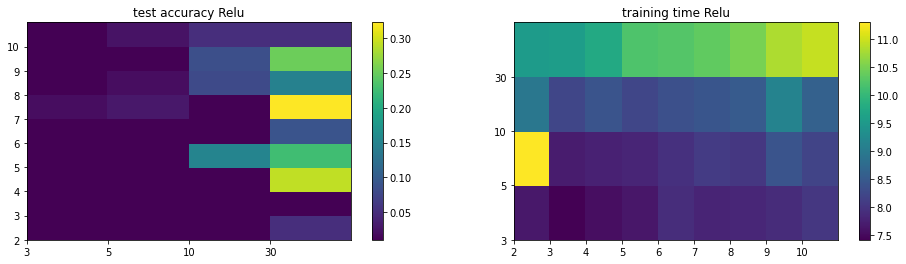

In [126]:
plt.figure(figsize=(16,4))
plt.subplot(121)

#dfr1=dfr.T.reindex(index=dfr.T.index[::-1])
dfr1=dfr
plt.pcolor(dfr1)
plt.xticks(np.arange(0, len(dfr1.columns), 1),dfr1.columns)
plt.yticks(np.arange(0, len(dfr1.index),1),dfr1.index)
plt.colorbar()
#plt.colormaps()
plt.title("test accuracy Relu")


#plt.figure(figsize=(16,4))
plt.subplot(122)
dftr1=dftr.T.reindex(index=dftr.T.index[::1])
#dftr1=dftr
plt.pcolor(dftr1)
plt.xticks(np.arange(0, len(dftr1.columns), 1),dftr1.columns)
plt.yticks(np.arange(0, len(dftr1.index),1),dftr1.index)
plt.colorbar()
plt.colormaps()
plt.title("training time Relu")
plt.show()

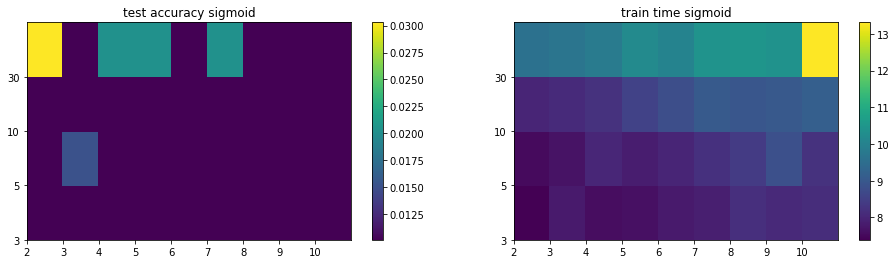

In [127]:
plt.figure(figsize=(16,4))
plt.subplot(121)

dfs1=dfs.T.reindex(index=dfs.T.index[::1])
#drs1=dfs
plt.pcolor(dfs1)
plt.xticks(np.arange(0, len(dfs1.columns), 1),dfs1.columns)
plt.yticks(np.arange(0, len(dfs1.index),1),dfs1.index)
plt.colorbar()
#plt.colormaps()
plt.title("test accuracy sigmoid")


#plt.figure(figsize=(16,4))
plt.subplot(122)
dfts1=dfts.T.reindex(index=dfts.T.index[::1])
#dfts1=dfts
plt.pcolor(dfts1)
plt.xticks(np.arange(0, len(dfs1.columns), 1),dfs1.columns)
plt.yticks(np.arange(0, len(dfs1.index),1),dfs1.index)
plt.colorbar()
plt.colormaps()
plt.title("train time sigmoid")
plt.show()

In [0]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde


### Set up a model with Keras and train 

In [0]:

class MyModel(Model):
    def __init__(self, bn1=False, bn2=False):
        super(MyModel, self).__init__()
        self.bn1 = bn1
        self.bn2 = bn2
            
    def build(self, input_shape):
        
        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)    
        
        self.w2 = self.add_weight(shape=(100, 300), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(300, ), initializer='random_normal', trainable=True, dtype=tf.float32)

        self.w3 = self.add_weight(shape=(300, 30), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b3 = self.add_weight(shape=(30, ), initializer='random_normal', trainable=True, dtype=tf.float32)
        
        self.w4 = self.add_weight(shape=(30,99 ), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b4 = self.add_weight(shape=(99, ), initializer='random_normal', trainable=True, dtype=tf.float32)        

        
    @tf.function
    def get_z1(self, X):
        return tf.matmul(X,self.w1)+self.b1
                
    @tf.function
    def get_z2(self, X):
        z1 = self.get_z1(X)
        a1 = relu(z1)
        return tf.matmul(a1,self.w2)+self.b2

    @tf.function
    def get_z3(self, X):
        z2 = self.get_z2(X)
        a2 = relu(z2)
        return tf.matmul(a2,self.w3)+self.b3
    
    @tf.function
    def get_z4(self, X):
        z3 = self.get_z3(X)
        a3 = relu(z3)
        return tf.matmul(a3,self.w4)+self.b4
        
    @tf.function
    def call(self, X):
        z4 = self.get_z4(X)
        a4 = softmax(z4)        
        return a4
        
    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1 = []
        self.hz2 = []
        self.hz3 = []
        self.hz4 = []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.hz3.append(self.get_z3(X_batch).numpy().flatten())
                self.hz4.append(self.get_z4(X_batch).numpy().flatten())
                self.hloss.append(loss_value)
    
    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)    
    
    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005, 
                         color=plt.cm.RdBu(255*i/len(s)), 
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(132)
        plot_z_history(self.hz1); plt.title("z1 (before activation function at layer 1)\nred signals the first epoch")
        plt.subplot(133)
        plot_z_history(self.hz4); plt.title("z2 (before activation function at layer 2)\nred signals the first epoch")

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy


In [0]:
#del model

100% (600 of 600) |######################| Elapsed Time: 0:06:28 Time:  0:06:28
100% (1560 of 1560) |####################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (1560 of 1560) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


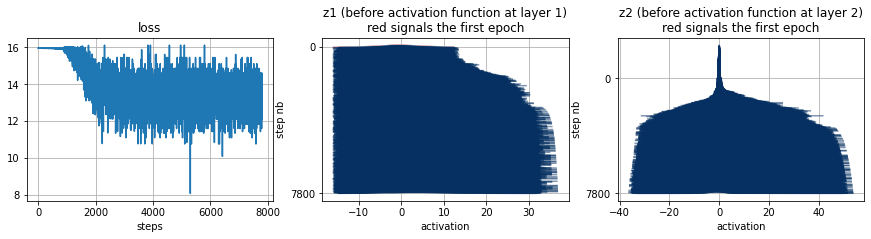

In [201]:
#instantiate the model
#sgd = SGD(lr=0.01, nesterov=True, decay=1e-3, momentum=0.9)
model = MyModel()
model.compile(optimizer= 'SGD', loss=categorical_crossentropy)
model.fit(x_trainif.astype(np.float32), np.eye(99)[y_train.astype(int)], epochs=600, batch_size=64)#x_train flatten and 
predict = lambda X: (model.predict(X)[:,0]>0.5).astype(int)
# model.summary()
model.plot_hist()

In [194]:
print ("train accuracy: %.3f" %(model.score(x_trainif, y_train)*100))
print ("test  accuracy : %.3f" %(model.score(x_testif, y_test)*100))

train accuracy: 18.056
test  accuracy : 15.657


100% (20 of 20) |########################| Elapsed Time: 0:00:17 Time:  0:00:17
100% (88 of 88) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (88 of 88) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


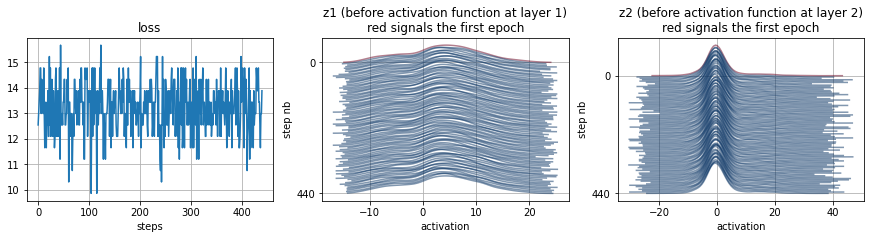

In [195]:
model.fit(x_trainif.astype(np.float32), np.eye(99)[y_train.astype(int)], epochs=20, batch_size=36)#x_train flatten and 
predict = lambda X: (model.predict(X)[:,0]>0.5).astype(int)
model.plot_hist()

In [197]:
print ("train accuracy: %.3f" %(model.score(x_trainif, y_train)*100))
print ("test  accuracy : %.3f" %(model.score(x_testif, y_test)*100))

train accuracy: 18.056
test  accuracy : 15.657
